# **다음 분기에 어떤 게임을 설계할까?**


# **목차**


### 1. 데이터 불러오기 및 전처리
### 2. 데이터 분석
##### - 지역에 따른 장르 선호도
##### - 연도별 게임 트렌드
##### - 출고량이 높은 게임 분석 및 시각화


### 3. 결론 도출


# **1. 데이터 불러오기 및 전처리**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import math
import re
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from pandas import DataFrame
from scipy.stats import chi2_contingency

In [ ]:
df_raw = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/project/vgames2.csv')
print(df_raw.info())
df_raw = df_raw.drop('Unnamed: 0', axis=1)
df_raw

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16598 entries, 0 to 16597
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   16598 non-null  int64  
 1   Name         16598 non-null  object 
 2   Platform     16598 non-null  object 
 3   Year         16327 non-null  float64
 4   Genre        16548 non-null  object 
 5   Publisher    16540 non-null  object 
 6   NA_Sales     16598 non-null  object 
 7   EU_Sales     16598 non-null  object 
 8   JP_Sales     16598 non-null  object 
 9   Other_Sales  16598 non-null  object 
dtypes: float64(1), int64(1), object(8)
memory usage: 1.3+ MB
None


,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
0,Candace Kane's Candy Factory,DS,2008.0,Action,Destineer,0.04,0,0,0
1,The Munchables,Wii,2009.0,Action,Namco Bandai Games,0.17,0,0,0.01
2,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010.0,Adventure,Alchemist,0,0,0.02,0
3,Deal or No Deal: Special Edition,DS,2010.0,Misc,Zoo Games,0.04,0,0,0
4,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010.0,Platform,D3Publisher,0.12,0.09,0,0.04
...,...,...,...,...,...,...,...,...,...
16593,Ice Age 2: The Meltdown,GC,2006.0,Platform,Vivendi Games,0.15,0.04,0,0.01
16594,Rainbow Islands: Revolution,PSP,2005.0,Action,Rising Star Games,0.01,0,0,0
16595,NBA 2K16,PS3,2015.0,Sports,Take-Two Interactive,0.44,0.19,0.03,0.13
16596,Toukiden: The Age of Demons,PSV,2013.0,Action,Tecmo Koei,0.05,0.05,0.25,0.03


In [ ]:
# sales 단위를 float(Million)으로 통일
# K제거 후 1000 으로 나누기
# M제거

def intonum(string):
  if 'K' in string:
    return float(string.replace('K',''))/1000
  elif 'M' in string:
    return float(string.replace('M',''))
  else:
    return float(string)

df_raw['NA_Sales'] = df_raw['NA_Sales'].apply(intonum)
df_raw['EU_Sales'] = df_raw['EU_Sales'].apply(intonum)
df_raw['JP_Sales'] = df_raw['JP_Sales'].apply(intonum)
df_raw['Other_Sales'] = df_raw['Other_Sales'].apply(intonum)

In [ ]:
# year 데이터에서 0(2000년)과 21(2021년) 사이를 기준으로 잡고 해당되면 2000(년)을 더하고, 
# 21과 100 사이를 기준으로 잡고 해당되면 1900(년)을 더한다.

def changeyear(year):
  if 0 <= year <= 21:
    return year + 2000
  elif 21 < year < 100: 
    return year + 1900
  else:
    return year

df_raw['Year'] = df_raw['Year'].apply(changeyear)

In [ ]:
# 위 과정을 통해 데이터셋 내 숫자단위를 통합할 수 있었다. 
# 그러나 Year 부분에는 여전히 수 많은 결측치가 존재한다.

df_raw.isnull().sum()

Name             0
Platform         0
Year           271
Genre           50
Publisher       58
NA_Sales         0
EU_Sales         0
JP_Sales         0
Other_Sales      0
dtype: int64

In [ ]:
# 결측값을 조건에 따라 다른 cols의 median 값으로 대체
# Platform과 Genre의 조합을 그룹으로 지정 > 각 그룹별 year 값들의 median을 구하고 year의 결측값으로 대체

def replace_na(df, condition_cols, cols):
  s = df.groupby(condition_cols)[cols].transform('median')
  return df.fillna(s.to_dict('series'))

df_raw = replace_na(df_raw, ['Platform', 'Genre'], ['Year'])


# 여전히 존재하는 genre와 publisher의 결측값은 각각 50, 58개로 전체 row 데이터에서 비중이 적으므로 drop한다.
df_raw = df_raw.dropna(axis=0)

df_raw.isnull().sum()

Name           0
Platform       0
Year           0
Genre          0
Publisher      0
NA_Sales       0
EU_Sales       0
JP_Sales       0
Other_Sales    0
dtype: int64

In [ ]:
# year 보기 좋게 float > int 로 변환
df_raw['Year'] = df_raw['Year'].astype(int)

df_raw

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
0,Candace Kane's Candy Factory,DS,2008,Action,Destineer,0.04,0.00,0.00,0.00
1,The Munchables,Wii,2009,Action,Namco Bandai Games,0.17,0.00,0.00,0.01
2,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010,Adventure,Alchemist,0.00,0.00,0.02,0.00
3,Deal or No Deal: Special Edition,DS,2010,Misc,Zoo Games,0.04,0.00,0.00,0.00
4,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010,Platform,D3Publisher,0.12,0.09,0.00,0.04
...,...,...,...,...,...,...,...,...,...
16593,Ice Age 2: The Meltdown,GC,2006,Platform,Vivendi Games,0.15,0.04,0.00,0.01
16594,Rainbow Islands: Revolution,PSP,2005,Action,Rising Star Games,0.01,0.00,0.00,0.00
16595,NBA 2K16,PS3,2015,Sports,Take-Two Interactive,0.44,0.19,0.03,0.13
16596,Toukiden: The Age of Demons,PSV,2013,Action,Tecmo Koei,0.05,0.05,0.25,0.03


In [ ]:
# Global_Sales 칼럼 추가하여 df 최종 완성시키기

df_raw['Total_Sales'] = df_raw['NA_Sales'] + df_raw['EU_Sales'] + df_raw['JP_Sales'] + df_raw['Other_Sales']
df_raw

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Total_Sales
0,Candace Kane's Candy Factory,DS,2008,Action,Destineer,0.04,0.00,0.00,0.00,0.04
1,The Munchables,Wii,2009,Action,Namco Bandai Games,0.17,0.00,0.00,0.01,0.18
2,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010,Adventure,Alchemist,0.00,0.00,0.02,0.00,0.02
3,Deal or No Deal: Special Edition,DS,2010,Misc,Zoo Games,0.04,0.00,0.00,0.00,0.04
4,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010,Platform,D3Publisher,0.12,0.09,0.00,0.04,0.25
...,...,...,...,...,...,...,...,...,...,...
16593,Ice Age 2: The Meltdown,GC,2006,Platform,Vivendi Games,0.15,0.04,0.00,0.01,0.20
16594,Rainbow Islands: Revolution,PSP,2005,Action,Rising Star Games,0.01,0.00,0.00,0.00,0.01
16595,NBA 2K16,PS3,2015,Sports,Take-Two Interactive,0.44,0.19,0.03,0.13,0.79
16596,Toukiden: The Age of Demons,PSV,2013,Action,Tecmo Koei,0.05,0.05,0.25,0.03,0.38


# **2. 데이터 분석**

## **2-1 지역에 따른 장르 선호도**

In [ ]:
# 장르를 index로 해서 장르별 세일즈를 총합한 새로운 dataframe 생성
df_country = df_raw.groupby('Genre').sum().reset_index()
df_country = df_country.melt(id_vars = 'Genre', value_vars = ['NA_Sales', 'EU_Sales','JP_Sales', 'Other_Sales'])
df_country = df_country.rename(
    columns = {
        'index': 'Genre', 
        'variable': 'Country', 
        'value': 'Sales'
        }
)

df_country['Country'] = df_country['Country'].str.replace("_Sales","")
df_country

,Genre,Country,Sales
0,Action,NA,874.52
1,Adventure,NA,105.53
2,Fighting,NA,221.53
3,Misc,NA,402.48
4,Platform,NA,446.44
5,Puzzle,NA,123.35
6,Racing,NA,357.19
7,Role-Playing,NA,319.54
8,Shooter,NA,581.91
9,Simulation,NA,182.96


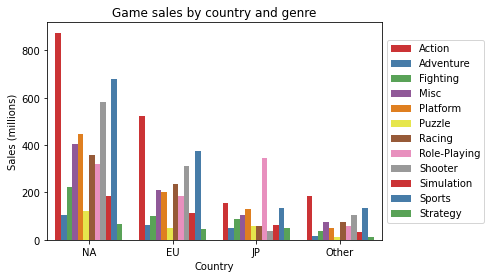

In [ ]:
g_country = sns.barplot(x = "Country", y = "Sales", hue = "Genre",
            data = df_country, palette = "Set1")
g_country.legend(loc='center left', bbox_to_anchor=(1, 0.5))
g_country.set_title("Game sales by country and genre")
g_country.set_ylabel("Sales (millions)");

**지역에 따라서 선호하는 게임 장르가 다를까?**
-  NA: Action > Sports > Shooter > Platform
-  EU: Action > Sports > Shooter > Racing
-  JP: Role-Playing > Action > Sports > Platform
-  Other: Action > Sports > Shooter > Racing


📌 위 그래프에서 볼 수 있듯이, action과 sport 부분은 전 지역에서 매출이 많았고, role-playing은 일본에서만 인기가 많았다. 그 다음으로는 shooter, racing, platform 등이 매출이 높았다.

In [ ]:
# Two-sample chi-square test를 통한 귀무가설 검정
# 귀무가설: 지역에 따른 장르 선호도가 존재하지 않는다.
# 대립가설: 지역에 따른 장르 선호도가 존재한다.
df_country_chi = df_raw.groupby('Genre').sum().reset_index()
df_country_chi = df_country_chi.set_index('Genre').drop(['Year','Total_Sales'], axis=1)
chi_sta1t, pvalue, dof, ex = chi2_contingency(np.array([df_country_chi]))
print("P-value: ", pvalue)

P-value:  2.761863438526949e-125


##### ✔️**가설검정**
p-value가 0.05보다 작은 0에 가까운 값으로 신뢰수준을 벗어난다. 이를 통해 귀무가설이 틀렸음을 확인할 수 있다. 

* 즉, 귀무가설을 기각하고 대립가설을 채택한다.

* 지역에 따른 장르 선호도가 존재한다. (지역과 게임 장르별 판매량은 연관이 있다)

## **2-2 연도별 게임 트렌드**

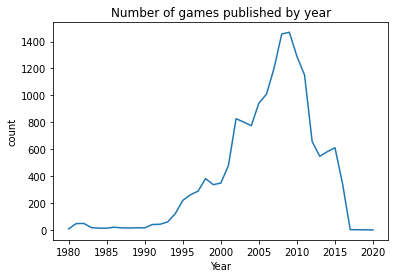

In [ ]:
# 연도별 게임 출고량 데이터 프레임 생성
df_year_total = df_raw[['Name','Year']].groupby('Year').count()

# 데이터 시각화
g_year_total = sns.lineplot(data = df_year_total, x = 'Year', y = 'Name')
g_year_total.set_ylabel("count")
g_year_total.set_title("Number of games published by year");

📌 위 그래프에서 볼 수 있듯이, 1990년 중반부터 2010년까지 게임 출고량이 피크를 이루었고, 그 뒤로는 점차 추세가 감소하고 있음.




In [ ]:
# 연도별 플랫폼당 게임 출고량 데이터 프레임 생성

df_year_platform = df_raw[['Year','Platform','Name']].groupby(['Platform','Year']).count().reset_index()
df_year_platform = df_year_platform.rename(columns = {"Name": "Count"})

df_year_platform

,Platform,Year,Count
0,2600,1980,9
1,2600,1981,48
2,2600,1982,49
3,2600,1983,12
4,2600,1984,1
...,...,...,...
236,XB,2008,1
237,XOne,2013,19
238,XOne,2014,61
239,XOne,2015,78


In [ ]:
px.bar(df_year_platform, x="Year", y="Count", color="Platform")

📌 위 차트에서 볼 수 있듯이, 약 5년 주기로 출시되는 플랫폼의 트렌드가 바뀌는 것을 볼 수 있다. 최근의 데이터에는 PS4(and PS3) > PSV > XOne 등의 플랫폼이 주류를 이루고 있다.

In [ ]:
# 연도별 장르당 게임 출고량 데이터 프레임 생성

df_year_genre = df_raw[['Year','Genre','Name']].groupby(['Genre','Year']).count().reset_index()
df_year_genre = df_year_genre.rename(columns = {"Name": "Count"})
df_year_genre

,Genre,Year,Count
0,Action,1980,1
1,Action,1981,25
2,Action,1982,24
3,Action,1983,7
4,Action,1984,1
...,...,...,...
383,Strategy,2012,15
384,Strategy,2013,19
385,Strategy,2014,8
386,Strategy,2015,17


In [ ]:
px.bar(df_year_genre, x="Year", y="Count", color="Genre")

📌 위 차트에서 볼 수 있는 사항은 다음과 같다.
- Action은 매해 꾸준히 전체 출고량 중 상당 부분을 차지한다.
- Sports와 Misc는 2000년대 초반부터 2010년대 초반까지 전체 출고량의 상당 부분을 차지했으나 그 후 출고량이 감소한다.
- 2000년 초반부터는 Adventure와 Role-Playing, Shooter 등이 전체 출고량의 일정부분을 차지한다.

In [ ]:
# 연도별 나라당 게임 출고량 데이터 프레임 생성

df_year_country = df_raw.groupby(['Year']).sum()
df_year_country = df_year_country.drop('Total_Sales',axis=1)
df_year_country

,NA_Sales,EU_Sales,JP_Sales,Other_Sales
Year,,,,
1980,10.57,0.67,0.00,0.11
1981,36.67,2.16,0.00,0.36
1982,31.82,1.95,0.00,0.33
1983,8.97,0.88,8.10,0.15
1984,33.28,2.10,14.27,0.70
1985,33.73,4.74,14.56,0.92
1986,12.50,2.84,19.81,1.93
1987,8.46,1.41,11.63,0.20
1988,23.87,6.59,15.76,0.99


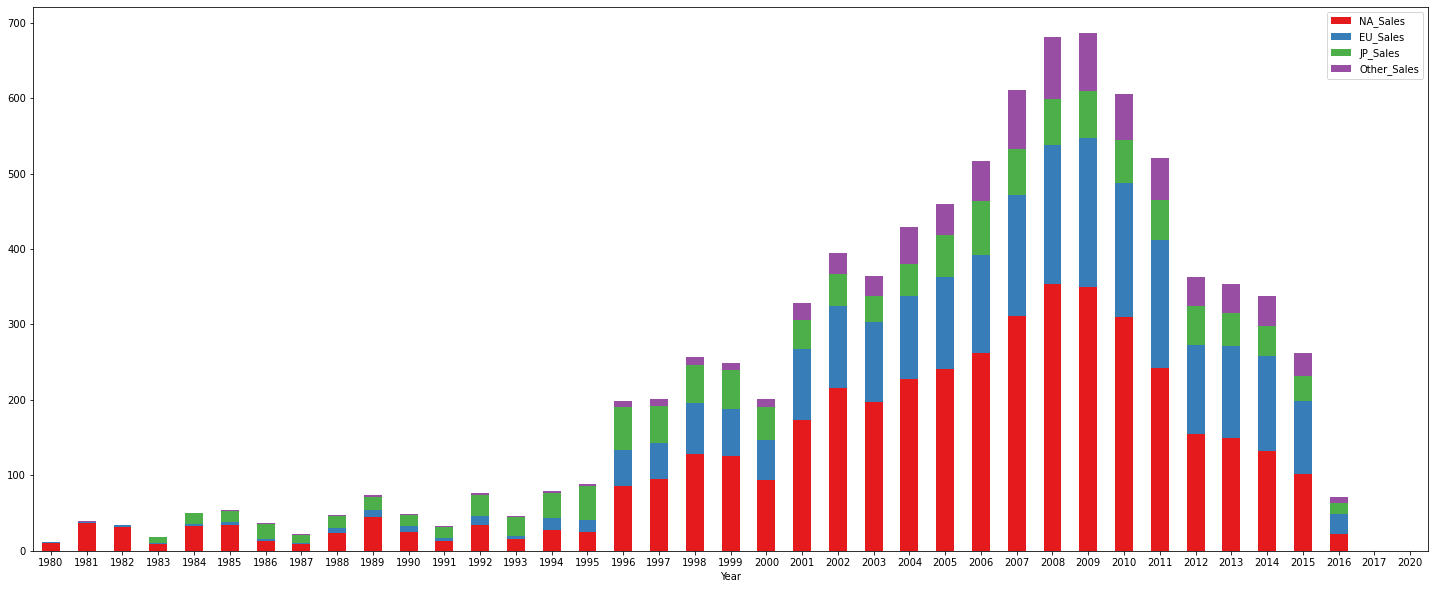

In [ ]:
g_year_country = df_year_country.plot.bar(stacked=True, figsize=(25,10), rot=0, color=sns.color_palette("Set1"))

📌 추가적으로 전 기간에 걸쳐 NA 지역이 네 개의 지역 중 가장 많은 연도별 판매고를 올리고 있다. (평균 판매고의 순위: **NA > EU > JP > Other**)

✔️ **연도별 게임의 트렌드가 있을까?**

전체적인 게임 출고량이 매해 줄어들고 있지만, 위 3개의 차트를 종합해볼 때 아래와 같은 결론을 도출 할 수 있다.
- 최근 PS4 플랫폼 출시 게임의 갯수가 가장 많아지고 있으며,
- Action 게임이 전체 출하량에서 가장 큰 부분을 유지하고 있고,
- 북미와 유럽이 전체 판매고 중에 가장 큰 부분을 차지한다.



## **2-3 출고량에 따른 게임 분석 및 시각화**


In [ ]:
# Total Sales을 기준으로 sales가 높은 9000개의 게임을 선정 
# 상위 9000개의 세일즈가 전체 세일즈의 약 95%(신뢰구간)을 차지

df_9000 = df_raw.nlargest(9000,'Total_Sales').reset_index().drop('index', axis=1)
df_9000


,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Total_Sales
0,Wii Sports,Wii,2006,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,Super Mario Bros.,NES,1985,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,Mario Kart Wii,Wii,2008,Racing,Nintendo,15.85,12.88,3.79,3.31,35.83
3,Wii Sports Resort,Wii,2009,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.38
...,...,...,...,...,...,...,...,...,...,...
8995,Pipe Mania,PS2,2008,Puzzle,Empire Interactive,0.07,0.05,0.00,0.02,0.14
8996,College Hoops 2K8,PS3,2007,Sports,Take-Two Interactive,0.13,0.00,0.00,0.01,0.14
8997,Naruto Shippuden: Ninja Destiny 3,DS,2006,Fighting,D3Publisher,0.00,0.01,0.13,0.00,0.14
8998,SingStar Vol. 3,PS3,2008,Misc,Sony Computer Entertainment,0.00,0.11,0.00,0.03,0.14


In [ ]:
# 상위 9000개가 총 세일즈의 약 95%을 차지함을 확인
print(df_raw['Total_Sales'].sum())
print(df_9000['Total_Sales'].sum())
print(8390/8848*100, "%")

8848.880000000001
8390.84
94.8236889692586 %


In [ ]:
# 최근 트렌드 확인을 위해 2010년 이후 데이터로만 total sales가 높은 9000개의 게임을 선정해서 진행.

df_9000_new = df_raw[df_raw['Year']>=2010].nlargest(9000,'Total_Sales').reset_index().drop('index', axis=1)
df_9000_new

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Total_Sales
0,Kinect Adventures!,X360,2010,Misc,Microsoft Game Studios,14.97,4.94,0.24,1.67,21.82
1,Grand Theft Auto V,PS3,2013,Action,Take-Two Interactive,7.01,9.27,0.97,4.14,21.39
2,Grand Theft Auto V,X360,2013,Action,Take-Two Interactive,9.63,5.31,0.06,1.38,16.38
3,Pokemon Black/Pokemon White,DS,2010,Role-Playing,Nintendo,5.57,3.28,5.65,0.82,15.32
4,Call of Duty: Modern Warfare 3,X360,2011,Shooter,Activision,9.03,4.28,0.13,1.32,14.76
...,...,...,...,...,...,...,...,...,...,...
5180,Shinobi Koutsutsu,PSP,2014,Adventure,Idea Factory,0.00,0.00,0.01,0.00,0.01
5181,Codename: Panzers Complete Collection,PC,2016,Strategy,Nordic Games,0.00,0.01,0.00,0.00,0.01
5182,Achtung Panzer: Kharkov 1943,PC,2010,Strategy,Mamba Games,0.00,0.01,0.00,0.00,0.01
5183,Arslan: The Warriors of Legend,XOne,2016,Action,Tecmo Koei,0.01,0.00,0.00,0.00,0.01


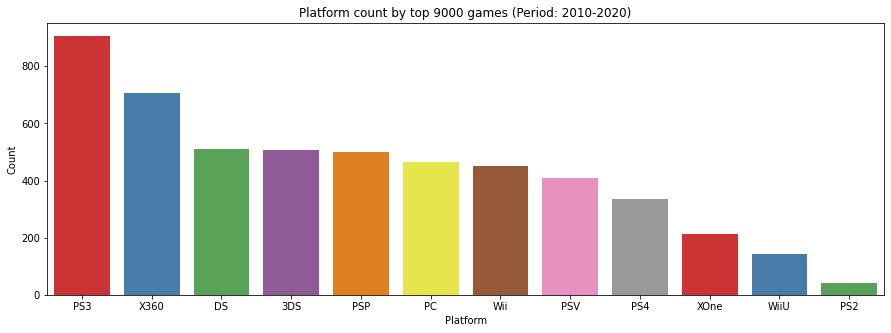

In [ ]:
# 주 판매고 게임의 플랫폼 당 갯수 확인을 위한 데이터프레임 생성
df_9000_new_platform = df_9000_new[['Platform','Name']].groupby('Platform').count().rename(columns = {"Name": "Count"}).reset_index()

# 데이터 시각화
fig, axes = plt.subplots(figsize=(15,5))
sns.barplot(data=df_9000_new_platform, x='Platform', y='Count', order=df_9000_new_platform.sort_values('Count',ascending=False).Platform, palette = "Set1");
axes.set_title('Platform count by top 9000 games (Period: 2010-2020)');

📌 위 차트를 통해 2010년부터는 주 판매고 게임들이 PS3 > X360 등의 플랫폼을 통해 출시되는 것을 알 수 있음.



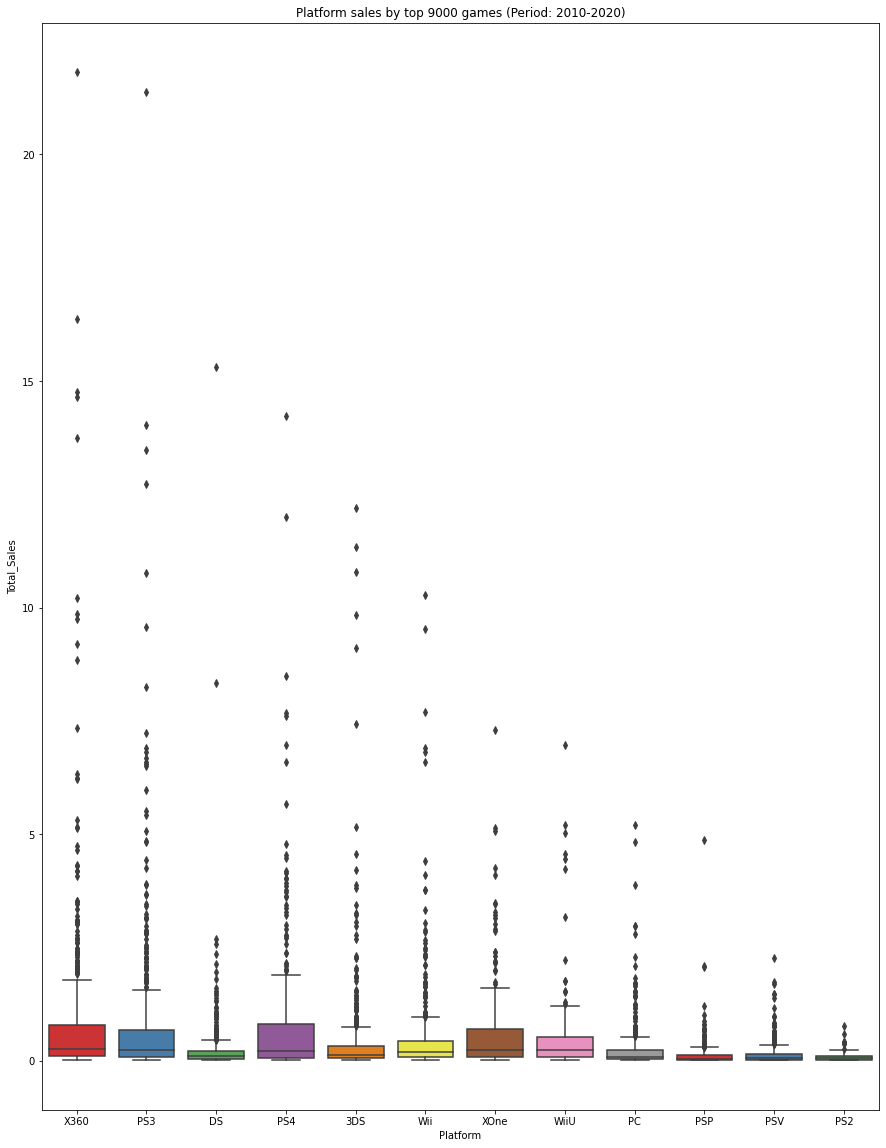

In [ ]:
fig, axes = plt.subplots(figsize=(15,20))

sns.boxplot(data=df_9000_new, x='Platform', y='Total_Sales', palette = "Set1") 
axes.set_title('Platform sales by top 9000 games (Period: 2010-2020)');

📌 주 판매고 게임에 대해 플랫폼 당 세일즈는 X360, PS3, PS4 등이 중간값도 높고 전체적인 판매고도 상위로 분포되어 있음을 알 수 있다.


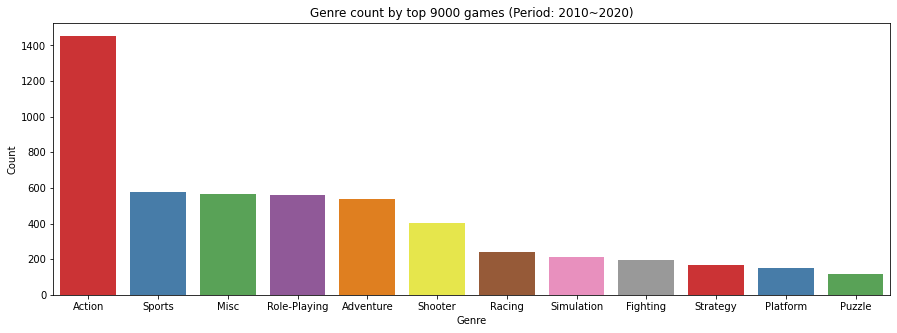

In [ ]:
# 2010년부터 주 판매고 게임의 장르 당 갯수 확인을 위한 데이터프레임 생성

df_9000_new_genre = df_9000_new[['Genre','Name']].groupby('Genre').count().rename(columns = {"Name": "Count"}).reset_index()

fig, axes = plt.subplots(figsize=(15,5))
sns.barplot(data=df_9000_new_genre, x='Genre', y='Count', order=df_9000_new_genre.sort_values('Count',ascending=False).Genre, palette = "Set1");
axes.set_title('Genre count by top 9000 games (Period: 2010~2020)');

📌 위 차트를 통해 2010년부터는 주 판매고 게임이 장르 **Action > Sports > Misc > RPG > Adventure > Shooter** 등의 순으로 출시되는 것을 볼 수 있다.




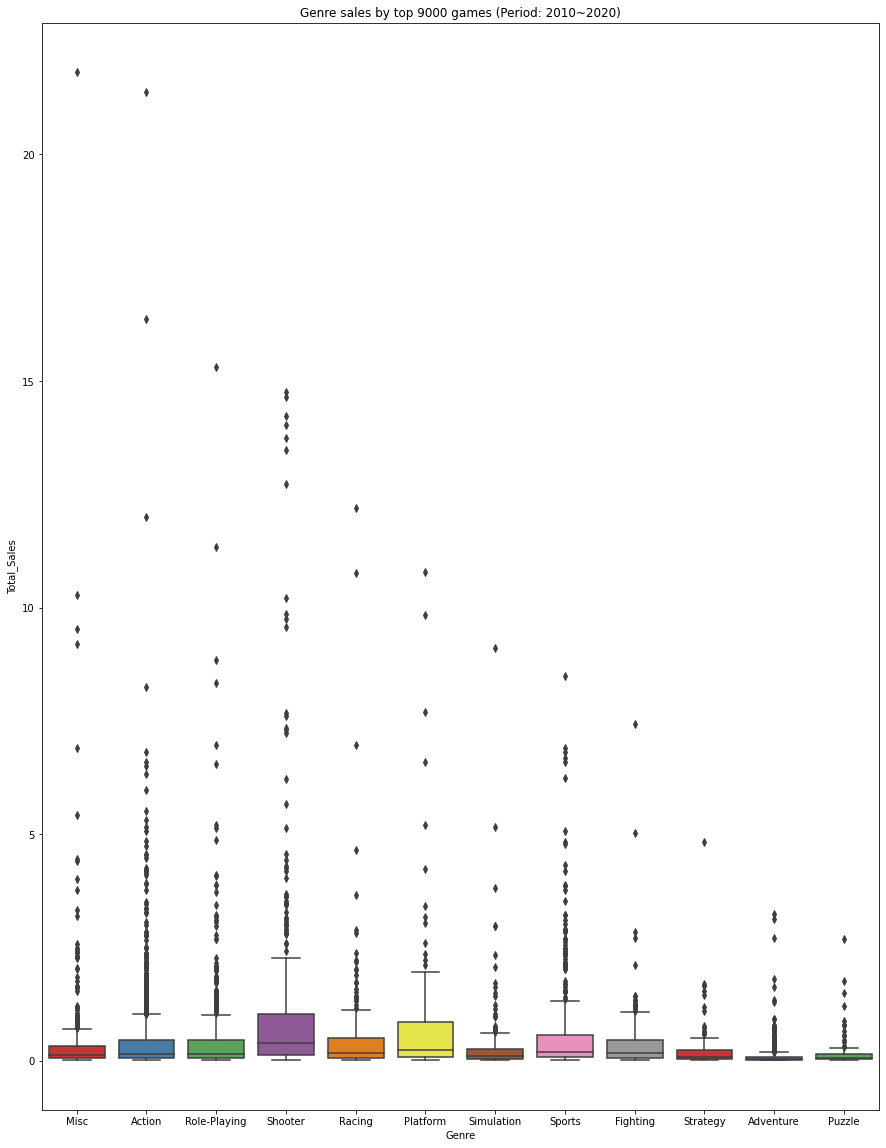

In [ ]:
fig, axes = plt.subplots(figsize=(15,20))
sns.boxplot(data=df_9000_new, x='Genre', y='Total_Sales', palette = "Set1")
axes.set_title('Genre sales by top 9000 games (Period: 2010~2020)');

📌 주 판매고 게임에 대해 장르 당 세일즈는 Shooter의 중간값과 전체적인 판매고가 상위로 분포되어 있음을 알 수 있다.


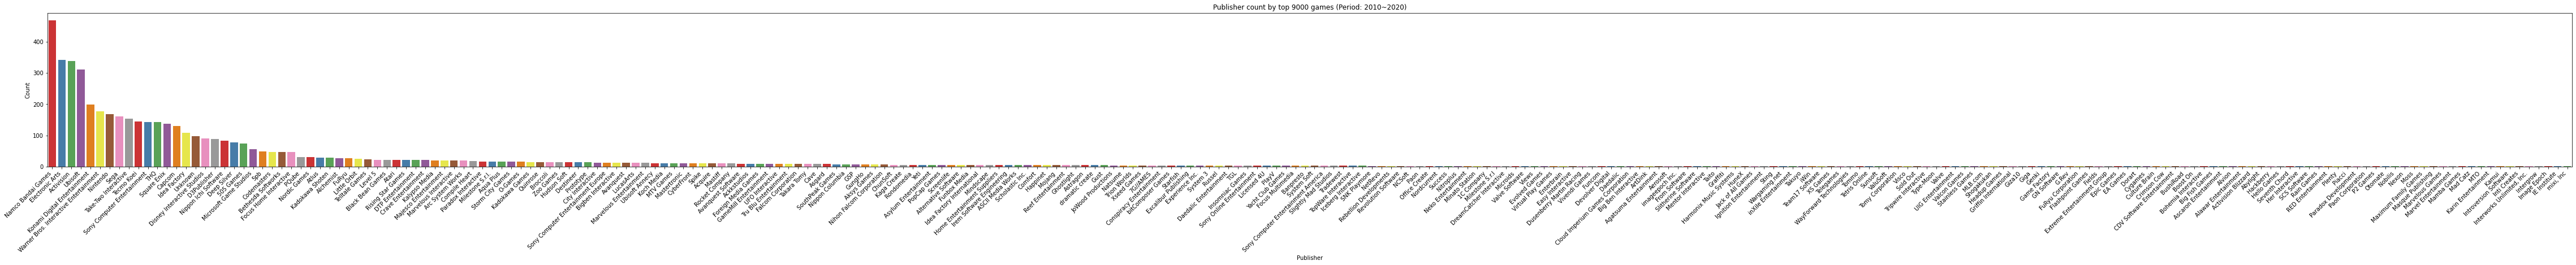

In [ ]:
# 2010년부터 주 판매고 게임의 퍼블리셔 당 갯수 확인을 위한 데이터프레임 생성

df_9000_new_publisher = df_9000_new[['Publisher','Name']].groupby('Publisher').count().rename(columns = {"Name": "Count"}).reset_index()

fig, axes = plt.subplots(figsize=(80,5))

sns.barplot( data=df_9000_new_publisher, x='Publisher', y='Count', order=df_9000_new_publisher.sort_values('Count',ascending=False).Publisher, palette = "Set1") 
axes.set_title('Publisher count by top 9000 games (Period: 2010~2020)');
plt.xticks(rotation=45, horizontalalignment='right');

In [ ]:
# 위 그래프를 표로 만들면 2010년부터의 주 판매고 게임의 퍼블리셔 당 출시갯수중 상위 5개는 아래와 같다.

df_9000_new_publisher_sort = df_9000_new_publisher.sort_values(by=['Count'], axis=0, ascending=False)
df_9000_new_publisher_sort.head(30)

,Publisher,Count
156,Namco Bandai Games,469
66,Electronic Arts,343
8,Activision,339
239,Ubisoft,312
127,Konami Digital Entertainment,199
251,Warner Bros. Interactive Entertainment,177
162,Nintendo,168
197,Sega,161
222,Take-Two Interactive,154
225,Tecmo Koei,144


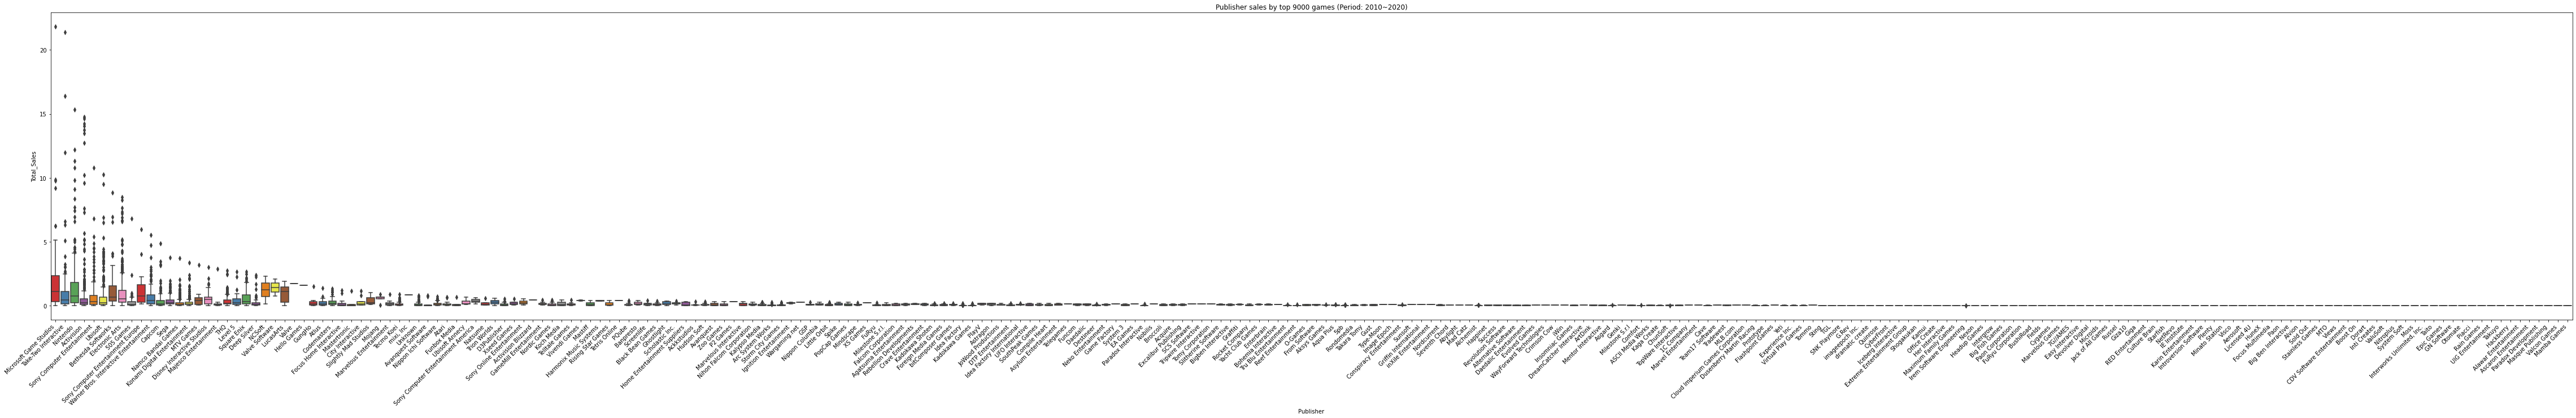

In [ ]:
fig, axes = plt.subplots(figsize=(80,10))

sns.boxplot(data=df_9000_new, x='Publisher', y='Total_Sales', palette = "Set1") # 2010년도 이후 출시된 게임 데이터
axes.set_title('Publisher sales by top 9000 games (Period: 2010~2020)');
plt.xticks(rotation=45, horizontalalignment='right');

📌 주 판매고 게임에 대해 퍼블리셔 당 세일즈는 Microsoft Game Studios > Take-Two Interactive > Nintendo 순으로 중간값과 전체적인 판매고가 상위로 분포되어 있음을 알 수 있다.


# 3. 결론 도출

위 데이터를 종합해보면, 다음과 같은 결론을 도출할 수 있다.
<br><br>
전체 게임시장의 규모가 작아지고, 게임 출시량이 줄면서 가장 잠재매출이 높을 것으로 예상되는 시장, 플랫폼, 장르, 퍼블리셔를 선정한다.
<br><br>
- 매출시장이 가장 높은 **북미 > 유럽** 순으로 타겟팅한다.
- 북미의 장르별 판매고는 Action > Sports > Shooter 순이고,
- 유럽의 장르별 판매고는 Action > Sports > Shooter 순이다.
<br><br>
- 그러나 최근 10년 데이터를 보면 **Shooter**가 출시량에 판매고가 월등히 높아짐을 알 수 있으므로 이메 맞춰 게임을 기획한다.
<br><br>
- 최근 10년 데이터를 보면 PS3, PS4, X360 플랫폼에서의 출시 된 게임의 판매고가 높음을 알 수 있고 **X360**과 가장 최신 버전인 **PS4**의 플랫폼에 맞춰 게임을 기획한다.
<br><br>
- 게임 발매(Publisher)는 출고량과 판매고가 동시에 높은 **Take-Two Interactive, Nintendo, Activision, Microsoft Game Studio**s을 통해서 한다

###📌북미와 유럽을 겨냥하여 Shooter 장르를 X360과 PS4 플랫폼에 맞춰 기획 및 개발하고 Take-Two Interactive, Nintendo, Activision, Microsoft Game Studio 등의 발매사를 통해 발매한다.